# Unit 2: Fisheries Collapse Module Overview

This module will focus on examining a crucial global issue and important scientific debate about the state of global fisheries.  In this module we will seek to reproduce some of the most widely cited examples of species collapse ever, and examine the evidence behind an influential and widely cited paper on global fisheries, [Worm et al 2006](http://doi.org/10.1126/science.1132294).  However, rather than use the limited data available to Boris Worm and colleagues in 2006, we will be drawing from the best and most recent stock asssement data available today to see how those patterns have faired.  

In this module we will also begin to master one of the most important concepts in data science: manipulation of tabular data using relational database concepts. Instead of working with independent data.frames, we will be working with a large relational database which contains many different tables of different sizes and shapes, but that all all related to each other through a series of different ids.  



## The Database

We will use data from the RAM Legacy Stock Assessment Database.  In order to better introduce some important emerging technologies, we will be accessing these data directly from a relatively new platform that is now playing a key role in data sharing in machine learning communities, with the memorable name, HuggingFace.  We will be streaming data from <https://huggingface.co/datasets/cboettig/ram_fisheries/tree/main/v4.65>.  We will have more to say about this approach as we progress.



## Researcher Spotlight: Daniel Pauly

Science is done by real people.  There are many influential and colorful characters in the global fisheries debate.  I want to highlight Professor Pauly not just because he is so famous, but as an early believer in Open Science and Data Science, before we had either of those words.  His contributions in making fisheries data more open were ground breaking for their time.  I'm also indebted to Professor Pauly whom I had the privilege to meet when I was a junior scientist who had only recently released one of my first software packages, aimed at making data from FishBase more accessible. Academic researchers are typically defined by scientific publications, not software, so I was shocked that Pauly already knew of my software package, and that he encouraged me to continue developing software.  Even today that is not common advice, but I believed him, and it's probably a good reason I am where I am today.  Scientific textbooks and courses are often critiqued for failing to recognize the contributions of those from minority backgrounds, but as the texts are written on global change ecology, I think none will omit the works for Professor Pauly.




## Science Introduction

Background abbreviated documentary, features many of the leading authors on both sides https://vimeo.com/44104959

In [1]:
import ibis
from ibis import _
import ibis.selectors as s
import seaborn.objects as so

In [2]:
con=ibis.duckdb.connect()
area_url="https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/area.csv?download=true"
area=con.read_csv(area_url)

assessment_url="https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/assessment.csv?download=true"
assessment=con.read_csv(assessment_url)

stock_url="https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/stock.csv?download=true"
stock=con.read_csv(stock_url)

timeseries_url="https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/timeseries.csv?download=true"
timeseries=con.read_csv(timeseries_url, nullstr = "NA")

tsmetrics_url="https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/tsmetrics.csv?download=true"
tsmetrics=con.read_csv(tsmetrics_url, nullstr = "NA")

In [3]:
tsmetrics.filter(_.tscategory=="CATCH or LANDINGS").select(_.tslong,_.tsunique).distinct().execute()

,tslong,tsunique
0,Catch divided by MSY calculated from reference...,CdivMSY-dvmb-ratio
1,Catch divided by MSY calculated from model-est...,CdivMSY-est-ratio
2,Catch or landings that is paired with TAC,Cpair-MT
3,Recreational catch,RecC-E00
4,Total allowable catch combined beyond just thi...,TAC-CMB-MT
...,...,...
63,Total landings. Use only when there is more th...,TL-4-MT
64,Total landings in subarea,TL-A2-MT
65,Total landings in subarea,TL-A4-MT
66,Total landings,TL-E00lbs


In [ ]:
fish=(timeseries
.rename(tsunique="tsid")
.join(tsmetrics,"tsunique")
.join(stock,["stockid","stocklong"])
.join(assessment,"assessid")
)

r0 := DatabaseTable: ibis_read_csv_rzsbgitclfel5jjgpvbxm5rgbe
  assessid  string
  stockid   string
  stocklong string
  tsid      string
  tsyear    int64
  tsvalue   float64

r1 := DatabaseTable: ibis_read_csv_gqby7jin5zegda2pkm4z4ufrau
  tscategory   string
  tsshort      string
  tslong       string
  tsunitsshort string
  tsunitslong  string
  tsunique     string

r2 := DatabaseTable: ibis_read_csv_7zigvjvvwbggjnqtkg5keeiw6y
  stockid         string
  tsn             int64
  scientificname  string
  commonname      string
  areaid          string
  stocklong       string
  region          string
  primary_country string
  primary_FAOarea int64
  ISO3_code       string
  GRSF_uuid       string
  GRSF_areaid     string
  inmyersdb       int64
  myersstockid    string
  state           string

r3 := DatabaseTable: ibis_read_csv_xdxe74onxfgzza6kcjbotsvjrm
  assessid       string
  assessorid     string
  stockid        string
  stocklong      string
  recorder       string
  daterecorded   timestamp(6)
  dateloaded     timestamp(6)
  assessyear     string
  assesssource   string
  contacts       string
  notes          string
  pdffile        string
  assess         int64
  refpoints      int64
  assessmethod   string
  assesscomments string
  xlsfilename    string
  mostrecent     int64

r4 := Project[r0]
  assessid:  r0.assessid
  stockid:   r0.stockid
  stocklong: r0.stocklong
  tsunique:  r0.tsid
  tsyear:    r0.tsyear
  tsvalue:   r0.tsvalue

r5 := JoinChain[r4]
  JoinLink[inner, r1]
    r4.tsunique == r1.tsunique
  JoinLink[inner, r2]
    r4.stockid == r2.stockid
    r4.stocklong == r2.stocklong
  JoinLink[inner, r3]
    r4.assessid == r3.assessid
  values:
    commonname: r2.commonname

Distinct[r5]

In [25]:
cod_catch=(fish
.filter(_.tscategory=="CATCH or LANDINGS")
.filter(_.tsunique == "TCbest-MT")
.filter(_.commonname=="Atlantic cod")
)

cod_catch

r0 := DatabaseTable: ibis_read_csv_rzsbgitclfel5jjgpvbxm5rgbe
  assessid  string
  stockid   string
  stocklong string
  tsid      string
  tsyear    int64
  tsvalue   float64

r1 := DatabaseTable: ibis_read_csv_gqby7jin5zegda2pkm4z4ufrau
  tscategory   string
  tsshort      string
  tslong       string
  tsunitsshort string
  tsunitslong  string
  tsunique     string

r2 := DatabaseTable: ibis_read_csv_7zigvjvvwbggjnqtkg5keeiw6y
  stockid         string
  tsn             int64
  scientificname  string
  commonname      string
  areaid          string
  stocklong       string
  region          string
  primary_country string
  primary_FAOarea int64
  ISO3_code       string
  GRSF_uuid       string
  GRSF_areaid     string
  inmyersdb       int64
  myersstockid    string
  state           string

r3 := DatabaseTable: ibis_read_csv_xdxe74onxfgzza6kcjbotsvjrm
  assessid       string
  assessorid     string
  stockid        string
  stocklong      string
  recorder       string
  daterecorded   timestamp(6)
  dateloaded     timestamp(6)
  assessyear     string
  assesssource   string
  contacts       string
  notes          string
  pdffile        string
  assess         int64
  refpoints      int64
  assessmethod   string
  assesscomments string
  xlsfilename    string
  mostrecent     int64

r4 := Project[r0]
  assessid:  r0.assessid
  stockid:   r0.stockid
  stocklong: r0.stocklong
  tsunique:  r0.tsid
  tsyear:    r0.tsyear
  tsvalue:   r0.tsvalue

r5 := JoinChain[r4]
  JoinLink[inner, r1]
    r4.tsunique == r1.tsunique
  JoinLink[inner, r2]
    r4.stockid == r2.stockid
    r4.stocklong == r2.stocklong
  JoinLink[inner, r3]
    r4.assessid == r3.assessid
  values:
    assessid:        r4.assessid
    stockid:         r4.stockid
    stocklong:       r4.stocklong
    tsunique:        r4.tsunique
    tsyear:          r4.tsyear
    tsvalue:         r4.tsvalue
    tscategory:      r1.tscategory
    tsshort:         r1.tsshort
    tslong:          r1.tslong
    tsunitsshort:    r1.tsunitsshort
    tsunitslong:     r1.tsunitslong
    tsn:             r2.tsn
    scientificname:  r2.scientificname
    commonname:      r2.commonname
    areaid:          r2.areaid
    region:          r2.region
    primary_country: r2.primary_country
    primary_FAOarea: r2.primary_FAOarea
    ISO3_code:       r2.ISO3_code
    GRSF_uuid:       r2.GRSF_uuid
    GRSF_areaid:     r2.GRSF_areaid
    inmyersdb:       r2.inmyersdb
    myersstockid:    r2.myersstockid
    state:           r2.state
    assessorid:      r3.assessorid
    stockid_right:   r3.stockid
    stocklong_right: r3.stocklong
    recorder:        r3.recorder
    daterecorded:    r3.daterecorded
    dateloaded:      r3.dateloaded
    assessyear:      r3.assessyear
    assesssource:    r3.assesssource
    contacts:        r3.contacts
    notes:           r3.notes
    pdffile:         r3.pdffile
    assess:          r3.assess
    refpoints:       r3.refpoints
    assessmethod:    r3.assessmethod
    assesscomments:  r3.assesscomments
    xlsfilename:     r3.xlsfilename
    mostrecent:      r3.mostrecent

r6 := Filter[r5]
  r5.tscategory == 'CATCH or LANDINGS'

r7 := Filter[r6]
  r6.tsunique == 'TCbest-MT'

Filter[r7]
  r7.commonname == 'Atlantic cod'

In [27]:
cod_catch.select(_.primary_FAOarea).distinct().execute()


,primary_FAOarea
0,21
1,27


In [35]:
cod_year = (
    cod_catch
        .mutate(FAO = _.primary_FAOarea.cast("str"))
        .group_by(_.tsyear, _.FAO)
        .agg(total_value = _.tsvalue.sum())
)

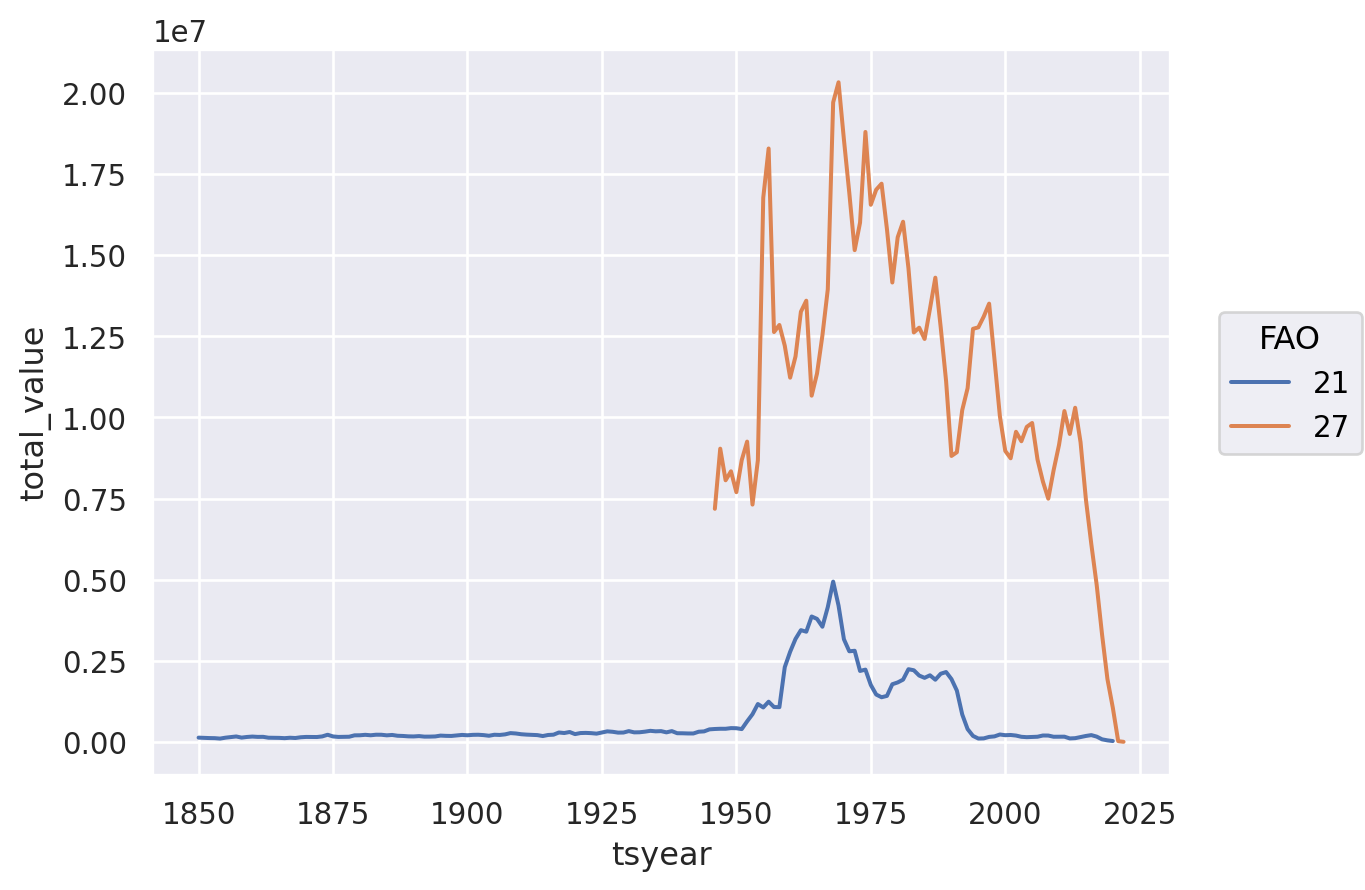

In [36]:
(so.Plot(data = cod_year, x = "tsyear", y = "total_value", color = "FAO")
    .add(so.Line())
    )

In [39]:
FAO_21 = cod_year.filter(_.FAO == "21")

FAO_21.head().execute()


,tsyear,FAO,total_value
0,1966,21,3549942.714
1,1971,21,2793434.421
2,1973,21,2187770.490
3,1974,21,2228233.724
4,1978,21,1418901.269


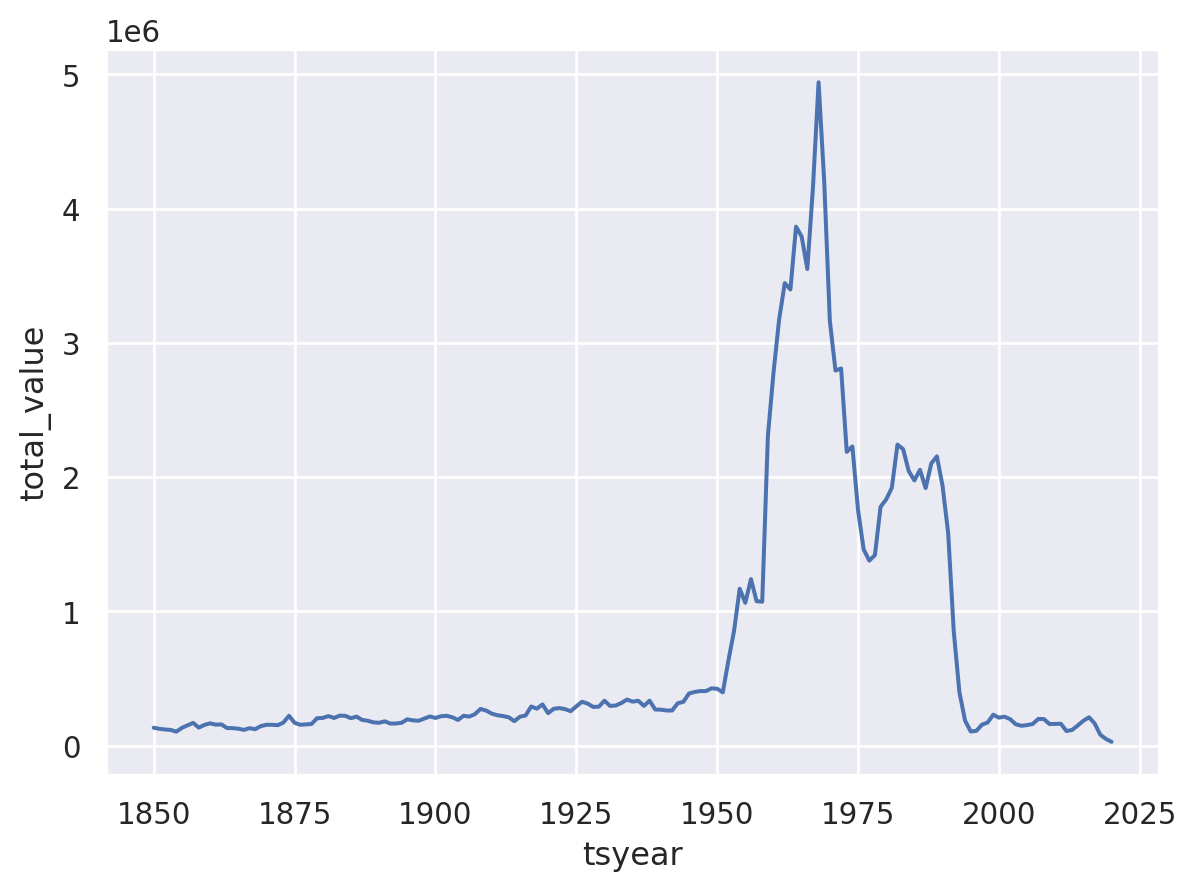

In [40]:
(so.Plot(data = FAO_21, x = "tsyear", y = "total_value")
    .add(so.Line())
    )


# Exercise 1: Investigating the North-Atlantic Cod

Now we are ready to dive into our data. First, We seek to replicate the following figure from the Millennium Ecosystem Assessment Project using the RAM data.

![](https://espm-157.github.io/website-r/img/cod.jpg)


# Excersise 2: Global Fisheries 

## Stock Collapses

We seek to replicate the temporal trend in stock declines shown in [Worm et al 2006](http://doi.org/10.1126/science.1132294):

![](https://espm-157.github.io/website-r/img/worm2006.jpg)